# Clasificarea sticlelor folosind mobilenet 

### 1. Importari module

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from keras import Model
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications.mobilenet import preprocess_input
import numpy as np
from IPython.display import Image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img, img_to_array
import pickle

2025-03-17 13:07:43.950857: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-17 13:07:44.896631: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### 2. Vizualizare si preprocesarea datelor

In [2]:
# functie cu care sa preluam toate numele imaginilor intr-un directoriu
def getFilenames(directory):
    pth = []
    for dirpath,_,filenames in os.walk(directory):
        for f in filenames:
            pth.append(os.path.join(dirpath, f))
    return pth

In [3]:
# obtinerea numelor imaginilor: "Non_Bottle" si "Bottles", creerea variabilelor target pentru ele

"""
nb - numarul de no bottles
b - numarul de sticle
"""

# prima data pentru cele care nu sunt sticle
path_no_bottles = "./data/Non_Bottles"

no_bottles_filesname = getFilenames(path_no_bottles)
no_bottles_filesname.sort()
targetnb = []
for i in range(len(no_bottles_filesname)):
    targetnb.append('nb')

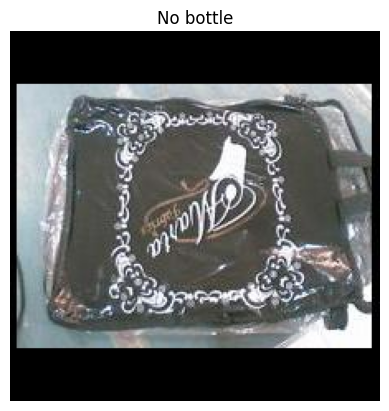

In [4]:
# vizualizare imagini no bottle
img_no_bottle = mpimg.imread('./data/Non_Bottles/not_bottle_3643.jpg')
plt.imshow(img_no_bottle)
plt.axis('off')
plt.title("No bottle")
plt.show()

In [5]:
# a doua oara pentru sticle
path_bottles = "./data/Bottles"

bottles_filesname = getFilenames(path_bottles)
bottles_filesname.sort()

targetb = []
for i in range(len(bottles_filesname)):
    targetb.append('b')

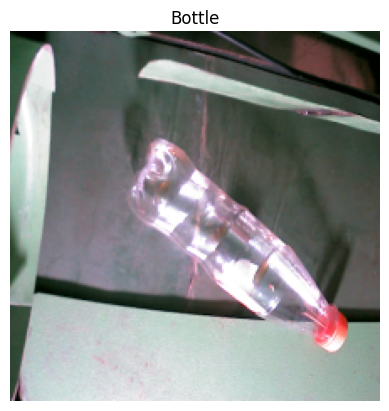

In [6]:
# vizualizare imagini bottles
img_small = mpimg.imread('./data/Bottles/smallbottle_676.png')
plt.imshow(img_small)
plt.axis('off')
plt.title("Bottle")
plt.show()

In [7]:
# afisarea numarului de imagini pentru fiecare categorie
print(f"Numarul pentru cele care nu sunt sticle: {len(targetnb)}\nNumarul pentru sticle: {len(targetb)}\n")

Numarul pentru cele care nu sunt sticle: 7305
Numarul pentru sticle: 45272



In [8]:
# combinam toate aceste imagini

target = targetnb + targetb
all_names = no_bottles_filesname + bottles_filesname
print(f"Numarul total de imagini: {len(target)}")

Numarul total de imagini: 52577


### 3. Preprocesarea datelor pentru training, testing si validation

In [9]:
# impartirea imaginilor in seturi de antrenare si testare
X_train, X_test, y_train, y_test = train_test_split(all_names, target, test_size = 0.2, random_state = 42, stratify = target)

# validare
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42, stratify = y_train)

In [10]:
# crearea de dataframes pentru antrenare, validare si testare
df_train = pd.DataFrame(columns = ['Images','target'])
df_validate = pd.DataFrame(columns = ['Images','target'])
df_test = pd.DataFrame(columns = ['Images','target'])

In [11]:
# punerea datelor respective in fiecare dataset

# antrenare
df_train['Images'] = X_train
df_train['target'] = y_train

# validare
df_validate['Images'] = X_val
df_validate['target'] = y_val

# testare
df_test['Images'] = X_test
df_test['target'] = y_test

In [12]:
# afisarea datasetului de antrenare
df_train.head()

,Images,target
0,./data/Bottles/bigapple500ml_1405.jpg,b
1,./data/Bottles/image_673.png,b
2,./data/Bottles/pepsijumbo_543.jpg,b
3,./data/Bottles/aquafina500ml_298.jpg,b
4,./data/Non_Bottles/no bottlesnobottle_726.png,nb


In [13]:
# afisarea datasetului de testare
df_test.head()

,Images,target
0,./data/Bottles/aquafina500ml_578.jpg,b
1,./data/Non_Bottles/image_85.png,nb
2,./data/Bottles/dew500ml_1712.jpg,b
3,./data/Bottles/2383.jpg,b
4,./data/Bottles/largebottle_2351.png,b


In [14]:
# afisarea datasetului de validare
df_validate.head()

,Images,target
0,./data/Bottles/7upgreen345ml_2118.jpg,b
1,./data/Bottles/mirinda1500ml_916.jpg,b
2,./data/Bottles/marinda500ml_1083.jpg,b
3,./data/Bottles/4992.jpg,b
4,./data/Bottles/gatoradeorange500ml_284.jpg,b


Checking the number of samples for each class in training dataset 

In [15]:
# verificarea la antrenare fiecarui numar de imagini la fiecare clasa (S/L/N)
df_train['target'].value_counts()

target
b     28973
nb     4675
Name: count, dtype: int64

In [16]:
# generator pentru incarcarea imaginilor si preprocesarea imaginilor pentru evitarea overfitting-ului
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True, 
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2
)

# luarea datelor din datasetul de antrenare
train_generator = training_datagen.flow_from_dataframe(
    dataframe = df_train,
    x_col = "Images",
    y_col = "target",
    target_size = (224, 224),
    batch_size = 32,
    color_mode = 'rgb',
    class_mode = 'binary',
    classes = {'b': 1, 'nb': 0}
  )

Found 33648 validated image filenames belonging to 2 classes.


In [17]:
# generator pentru imaginile validate fara preprocesarea lor, ele fiind reale (doar le normalizam)
val_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = False,
    vertical_flip = False
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe = df_validate,
    x_col = "Images",
    y_col = "target",
    target_size = (224, 224),
    batch_size = 32,
    color_mode = 'rgb',
    class_mode = 'binary',
    classes = {'b': 1, 'nb': 0}
)

Found 8413 validated image filenames belonging to 2 classes.


In [18]:
# generator pentru imaginile de testare (la fel ca cele de validare, doar normalizare, ele fiind si imagini cu zgomot)
test_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = False,
    vertical_flip = False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = df_test,
    x_col = "Images",
    y_col = "target",
    target_size = (224, 224),
    batch_size = 32,
    color_mode = 'rgb',
    class_mode = 'binary',
    classes = {'b': 1, 'nb': 0}
)

Found 10516 validated image filenames belonging to 2 classes.


### 4. Antrenare, validare si testare

In [19]:
# definirea dimensiunii si canalelor imaginilor si modelului preantrenat cu ponderi de baza
IMG_SHAPE = (224, 224, 3)

# incarcarea modelului pre antrenat
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='./mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5'
)

# adaugare straturi suplimentare
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
preds = Dense(1, activation='sigmoid')(x)

# initializare si descriere model
model = Model(inputs=base_model.input, outputs=preds)
model.summary()

2025-03-17 13:12:29.577896: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-17 13:12:29.670626: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-17 13:12:29.671249: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [22]:
# fine tuning la model pentru un model mai complex si mai flexibil

# inghetarea straturilor initiale si antrenarea doar struturilor noi
for layer in base_model.layers:
    layer.trainable = False

# compilarea modelului
model.compile(optimizer = Adam(learning_rate = 0.001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# salvarea celui mai bun model
model_checkpoint = ModelCheckpoint(
    "./models/best_model.h5",
    save_best_only = True,
    verbose = 1,
    monitor = 'val_loss',
    mode = 'min'
)

# antrenare initiala
history = model.fit(
    train_generator,
    epochs = 5,
    validation_data = val_generator,
    callbacks = [model_checkpoint]
)

Epoch 1/5


2025-03-17 13:20:26.615401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1052/1052 [==============================] - ETA: 0s - loss: 0.0225 - accuracy: 0.9923

2025-03-17 13:24:18.140292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.01223, saving model to ./models/best_model.h5
1052/1052 [==============================] - 245s 230ms/step - loss: 0.0225 - accuracy: 0.9923 - val_loss: 0.0122 - val_accuracy: 0.9964
Epoch 2/5
1052/1052 [==============================] - ETA: 0s - loss: 0.0138 - accuracy: 0.9951
Epoch 2: val_loss improved from 0.01223 to 0.00681, saving model to ./models/best_model.h5
1052/1052 [==============================] - 236s 224ms/step - loss: 0.0138 - accuracy: 0.9951 - val_loss: 0.0068 - val_accuracy: 0.9970
Epoch 3/5
1052/1052 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9956
Epoch 3: val_loss improved from 0.00681 to 0.00445, saving model to ./models/best_model.h5
1052/1052 [==============================] - 235s 223ms/step - loss: 0.0120 - accuracy: 0.9956 - val_loss: 0.0045 - val_accuracy: 0.9987
Epoch 4/5
1052/1052 [==============================] - ETA: 0s - loss: 0.0111 - accuracy: 0.9963
Epoch 4: val_loss did not im

In [23]:
# salvam istoricul antrenarii initiale pentru grafice de overfitting
with open('models/history_initial.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [24]:
# fine tuning -> dezghetarea ultimelor 30 de straturi
for layer in base_model.layers[-30:]:
    layer.trainable = True

# recompilarea cu un learnign rate mai mic
model.compile(optimizer = Adam(learning_rate = 0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# continuarea antrenarii
history_finetune = model.fit(
    train_generator,
    epochs = 5,
    validation_data = val_generator,
    callbacks = [model_checkpoint]
)

Epoch 1/5


2025-03-17 13:40:16.740141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1052/1052 [==============================] - ETA: 0s - loss: 0.0631 - accuracy: 0.9903

2025-03-17 13:44:08.819304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from 0.00445 to 0.00164, saving model to ./models/best_model.h5
1052/1052 [==============================] - 245s 226ms/step - loss: 0.0631 - accuracy: 0.9903 - val_loss: 0.0016 - val_accuracy: 0.9994
Epoch 2/5
1052/1052 [==============================] - ETA: 0s - loss: 0.0069 - accuracy: 0.9974
Epoch 2: val_loss improved from 0.00164 to 0.00145, saving model to ./models/best_model.h5
1052/1052 [==============================] - 236s 224ms/step - loss: 0.0069 - accuracy: 0.9974 - val_loss: 0.0014 - val_accuracy: 0.9995
Epoch 3/5
1052/1052 [==============================] - ETA: 0s - loss: 0.0080 - accuracy: 0.9980
Epoch 3: val_loss did not improve from 0.00145
1052/1052 [==============================] - 236s 224ms/step - loss: 0.0080 - accuracy: 0.9980 - val_loss: 0.0057 - val_accuracy: 0.9987
Epoch 4/5
1052/1052 [==============================] - ETA: 0s - loss: 0.0068 - accuracy: 0.9980
Epoch 4: val_loss did not improve from 0.00145
1052/1052 [==========

In [25]:
# salvam si cel dupa fine tuning sa vedem diferenta
with open('models/history_finetune.pkl', 'wb') as file:
    pickle.dump(history_finetune.history, file)

### 6. Grafice modele initiale si dupa fine tuning

In [26]:
# incarcam istoricele
with open('models/history_initial.pkl', 'rb') as file:
    history_initial = pickle.load(file)

with open('models/history_finetune.pkl', 'rb') as file:
    history_finetune = pickle.load(file) 

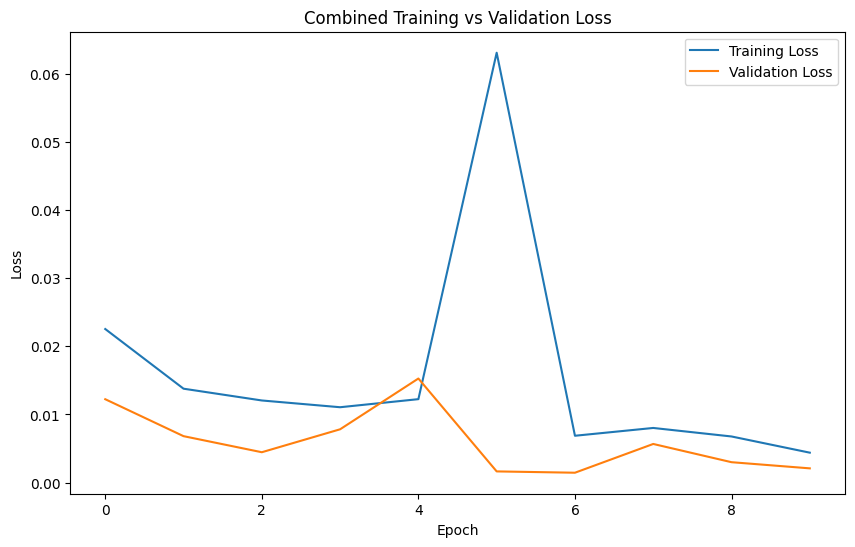

In [27]:
combined_history = {
    'loss': history_initial['loss'] + history_finetune['loss'],
    'accuracy': history_initial['accuracy'] + history_finetune['accuracy'],
    'val_loss': history_initial['val_loss'] + history_finetune['val_loss'],
    'val_accuracy': history_initial['val_accuracy'] + history_finetune['val_accuracy']
}

plt.figure(figsize=(10, 6))
plt.plot(combined_history['loss'], label='Training Loss')
plt.plot(combined_history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Combined Training vs Validation Loss')
plt.legend()
plt.show()

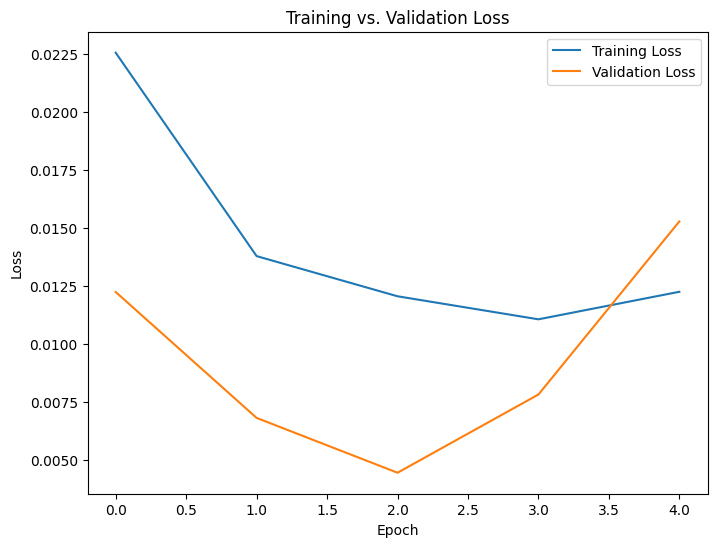

In [34]:
# loss separat
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

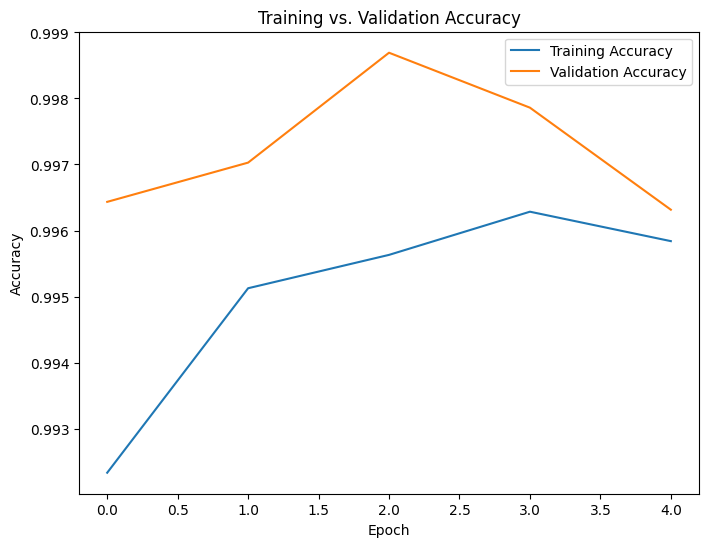

In [35]:
# accuracy separat
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 7. Predictii si testare model

In [28]:
# incarcarea modelului

best_model = load_model('./models/best_model.h5')

# evaluarea pe datele de test
loss, accuracy = best_model.evaluate(val_generator)
print(f"Val Loss: {loss}")
print(f"Val Accuracy: {accuracy}")

2025-03-17 14:00:06.414616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


263/263 [==============================] - 12s 45ms/step - loss: 0.0014 - accuracy: 0.9995
Val Loss: 0.0014478707453235984
Val Accuracy: 0.9995245337486267


In [33]:
# predictii pe date noi
def predict_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = tf.image.resize(img_array, (224, 224))
    img_array = np.expand_dims(img_array, axis=0) / 255.

    prediction = best_model.predict(img_array)[0][0]
    print(f"Probabilitate: {prediction:.4f}") 
    
    return "no bottle" if prediction > 0.5 else "bottle"

print(predict_image('./test/20250311_154953.jpg'))

1/1 [==============================] - 0s 16ms/step
Probabilitate: 0.0000
bottle
